In [1]:
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
from typing import Dict, List
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.structures.population_data import PopulationData
from datetime import datetime
import pandas as pd
from scipy import stats
seed = 1997

In [32]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
# paths
filepaths = {
    "lip": "D:/data/session_struct/lip/neurons/",
    "pfc": "D:/data/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}

In [33]:
for area in areas:
    path = filepaths[area]
    neu_path = path + "*neu.h5"
    path_list = glob.glob(neu_path)

In [40]:
attr_dtype = {'sp_samples':np.float16,'cluster_ch':np.float16,'cluster_number':np.float16,'block':np.float16,'trial_error':np.float16,'sample_id':np.float16,
              'test_stimuli':np.float16,'test_distractor':np.float16,'cluster_id':np.float16,'cluster_depth':np.float16,'code_samples':np.float16,
              'position':np.float16,'pos_code':np.float16,'code_numbers':np.float16}
popu=PopulationData.get_population(path_list[:50], attr_dtype)

100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


In [35]:
popu.population[0].area

'lip'

In [14]:
def get_matrix_position(neu_data,matrix,ch_start):
    cluster_ch = neu_data.cluster_ch - ch_start
    matrix = matrix - matrix.min().min()
    row, col = np.where(cluster_ch == matrix)
    return row,col

In [53]:
def get_ch_info(neu:NeuronData,params:List[Dict]):
    res = {}
    res["nid"] = neu.get_neuron_id()
    if neu.area != 'lip':
        ch_start = np.load(
            params['sessions_path']
            + neu.date_time
            + "/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/KS"
            + neu.area.upper()
            + "/channel_map.npy"
        )[0][0]
        matrix_df = pd.read_csv(
            params['ch_path'] + neu.area + "_ch_pos.csv",
            header=0,
            index_col=0,
        )
        matrix = matrix_df.values
        row,col=get_matrix_position(neu,matrix,ch_start)
    else:
        row,col=[int(neu.cluster_ch)],[0]
    res["ch_row"]=row[0]
    res["ch_col"]=col[0]
    return res

In [54]:
ch_path = 'C:/Users/camil/Documents/int/code/Users/losadac/data_stats/'
sessions_path = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/openephys/Riesling/'
params={'ch_path':ch_path, 'sessions_path':sessions_path}
df_ch=popu.execute_function(get_ch_info,params=params,n_jobs=1,ret_df=True)
df_ch

100%|██████████| 50/50 [00:00<00:00, 42573.12it/s]


,nid,ch_row,ch_col
0,mua3LIP2023-10-18_10-57-56Riesling,21,0
1,mua4LIP2023-10-18_10-57-56Riesling,7,0
2,mua5LIP2023-10-18_10-57-56Riesling,11,0
3,mua6LIP2023-10-18_10-57-56Riesling,12,0
4,mua7LIP2023-10-18_10-57-56Riesling,15,0
5,good1LIP2023-10-18_10-57-56Riesling,19,0
6,mua8LIP2023-10-18_10-57-56Riesling,22,0
7,mua9LIP2023-10-18_10-57-56Riesling,23,0
8,mua10LIP2023-10-18_10-57-56Riesling,25,0
9,mua11LIP2023-10-18_10-57-56Riesling,26,0


In [48]:
ch=[]
for i in range(len(popu.population)):
    ch.append(int(popu.population[i].cluster_ch))

(array([1., 7., 4., 8., 9., 5., 2., 3., 4., 7.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

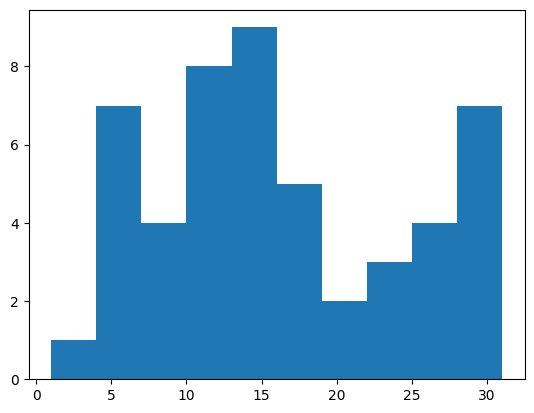

In [52]:
plt.hist(ch)